# Computer Vision

Before I start coding here are some important computer vision libraries
<table>
    <thead>Pytorch module
        <tr>
            <th>Pytorch Module</th>
            <th>What does it do?</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td> Torchvision </td>
            <td> Constains datasets, models, transformations used in computervision</td>
        </tr>
        <tr>
            <td> torchvision.datasets </td>
            <td> Constains datasets that can be loaded like FashionMnist. also contains base classes to make custom datasets</td>
        </tr>
        <tr>
            <td> torchvision.models </td>
            <td> Constains mpretrained models and architectures that can be used</td>
        </tr>
        <tr>
            <td> torchvision.trasnformations </td>
            <td> Constains a series of transformations that can be used on images and videos</td>
        </tr>
        <tr>
            <td> torch.utils.data.Dataset </td>
            <td> Base class for dataset</td>
        </tr>
        <tr>
            <td> torch.utils.data.DataLoader </td>
            <td> Creates python iterable over dataset</td>
        </tr>
    </tbody>

</table>

In [3]:
# imports
import torch
import torch.nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor 

# plotting
import matplotlib.pyplot as plt

In [6]:
# getting a dataset (Fashion Mnist)
train_data = datasets.FashionMNIST(
    root='data', 
    train=True,  
    download=True, 
    transform=torchvision.transforms.ToTensor(), # how do we transform the data?
    target_transform=None # how do we transform the targets?
    )

test_data = datasets.FashionMNIST(
    root='data', 
    train=False,  
    download=True, 
    transform=torchvision.transforms.ToTensor(), # how do we transform the data?
    target_transform=None # how do we transform the targets?
    )

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [47]:
# storing class names and indices.
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
image, label = train_data[0] # image shape (1,28,28)


# Visualise the dataset

* Use plt.imshow to visualise the data.
* Matplot lib expects only 2 dimensions (h,w) or it expects (h,w,c) with color channels being last.

Text(0.5, 1.0, 'Ankle boot')

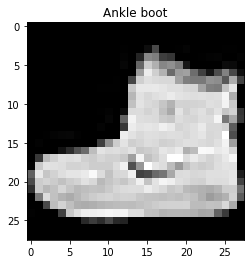

In [50]:
# squeeze the image to remove the 1st dimension. This leaves with just (h,w)
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])

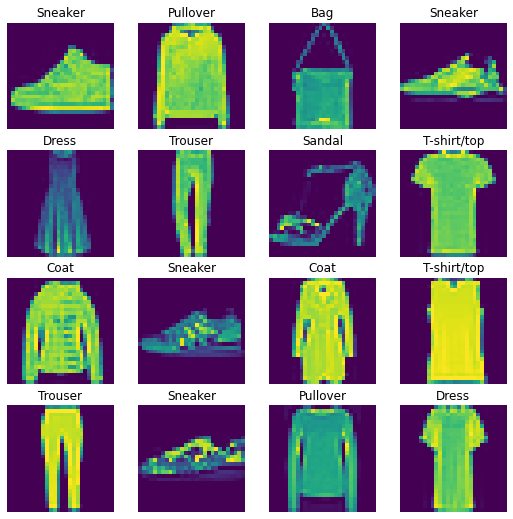

In [58]:
fig = plt.figure(figsize=(9,9))
rows,cols = 4,4
for i in range (1, rows*cols+1):
    random_indx = torch.randint(0,len(train_data), size=[1]).item()
    image,label = train_data[random_indx]
    fig.add_subplot(rows,cols, i)
    plt.imshow(image.squeeze())
    plt.title(class_names[label])
    plt.axis(False)

# Put the data into Dataloader to make it python iterable
